# Collaborative filtering methods

<b>Collaborative filtering</b> is recommendation strategy which uses the information about users' ratings historical data.

I will focus on two approaches:

1. <b>Memory-based</b>
    * <b>User-based</b> - item’s rating for a user is calculated depending on that items’ ratings by other similar users
    * <b>Item-based</b> - item’s rating is predicted based on how similar items have been rated by the user [1]
 
 
2. <b>Model-based</b> 
    * <b>Matrix factorization</b> - decomposing the ratings matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.[3]

In this project the recommendation engine will the Surprise library in Python.


## Import libraries

In [1]:
import pandas as pd
import random
#visualization
import matplotlib.pyplot as plt
import dexplot
#recommendation models
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans,NormalPredictor, SVD, SVDpp
from surprise import accuracy
#custom packages
from eda import show_df_info, show_duplicates, choose_values, grouping, check_ratings, unique_values, rows_number
from recommend import get_top_n, get_names
from model_graf import plot_diff, grid_knn, find_idx, hiper_visual

## Data

1. <b>Ratings</b> - contain information how users rated specific books.

    Columns:
    * user_id
    * book_id
    * rating


2. <b>Books</b> - contain some information about books. In this notebook only few columns will be used.

    Columns:
    * book_id
    * title
    * authors

In [2]:
ratings = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/ratings.csv')

books = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/books.csv', 
                    usecols=['book_id','title','authors'])

## Exploatory Data Analysis

Let's check how data looks like, if there are any NaN values or duplicated rows.

In [3]:
show_df_info(df=ratings)

Header : 


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


Number of rows is 5976479
Number of NaN values in each column : 


user_id    0
book_id    0
rating     0
dtype: int64

 Number of unique values in user_id column is 53424
 Number of unique values in book_id column is 10000
 Number of unique values in rating column is 5


Let's check if any user rated the same book more than once.

In [4]:
show_duplicates(df=ratings[['user_id','book_id']])

Number of duplicated rows : 


0

Luckily it didn't happen. Now let's check information about books.

In [5]:
show_df_info(df=books)

Header : 


,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


Number of rows is 10000
Number of NaN values in each column : 


book_id    0
authors    0
title      0
dtype: int64

 Number of unique values in book_id column is 10000
 Number of unique values in authors column is 4664
 Number of unique values in title column is 9964


Information about well-known book 'Harry Potter and the Sorcerer's Stone' is shown above. It is obvious that the author of this book is J.K. Rowling. Mary GrandPré is an illustrator. Only information about the author is needed in order to identify the book. In this case I will leave only one person name in the author column. Even if a book has more than one author it still will be easy to find if we knew one author + title.

In [3]:
books.authors = books.authors.str.partition(',')[0]

In [7]:
show_duplicates(df=books)

Number of duplicated rows : 


0

In [8]:
unique_values(df=books)

 Number of unique values in book_id column is 10000
 Number of unique values in authors column is 3888
 Number of unique values in title column is 9964


There is almost a 6 million ratings - it would be hard to process such amount of data. I have to reduce the number of observations. The data contain infomation about 10000 books and ratings given by 53424 different users.
I will randomly choose around 5% of users and limite the number of books by choosing only half of them with the highest number of ratings.

In [4]:
random.seed(5)

In [5]:
n = 0.05
ratings = choose_values(n=n, 
                        df=ratings, 
                        col_name='user_id')

In [6]:
rows_number(df=ratings)

Number of rows is 299308


In [7]:
grouped_by_book = grouping(data=ratings,col_name='book_id').sort_values()

In [8]:
ratings = ratings[ratings.book_id.isin(grouped_by_book[5000:].index)]

In [9]:
rows_number(df=ratings)

Number of rows is 261232


Let's see the distribution of number of ratings per book:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


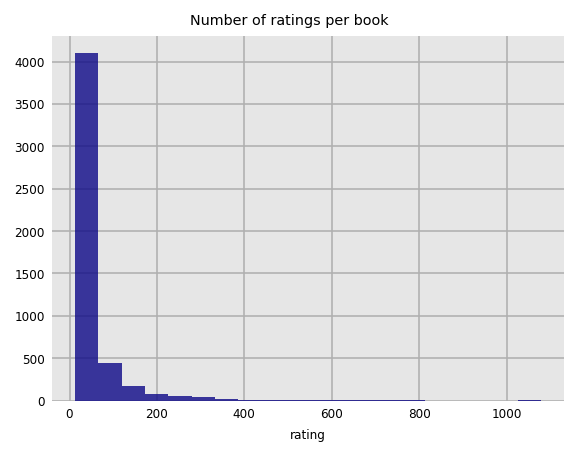

Statistics for dataframe grouped by book_id:
count    4987.000000
mean       52.382595
std        83.432535
min        13.000000
25%        17.000000
50%        26.000000
75%        49.000000
max      1079.000000
Name: rating, dtype: float64


In [10]:
check_ratings(data=ratings, col_name='book_id')

Let's see the distribution of number of books ratings per user:

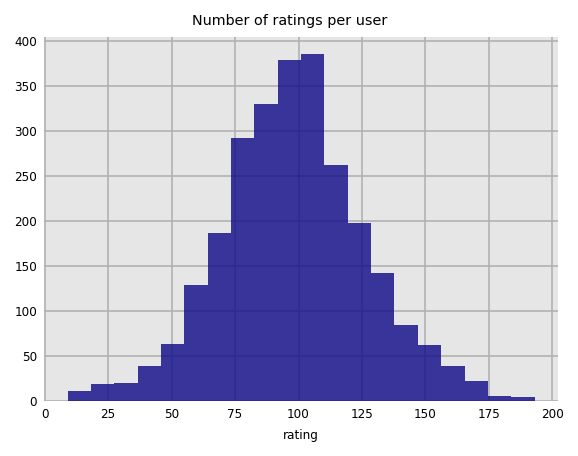

Statistics for dataframe grouped by user_id:
count    2671.000000
mean       97.803070
std        28.093466
min         9.000000
25%        80.000000
50%        98.000000
75%       115.000000
max       193.000000
Name: rating, dtype: float64


In [11]:
check_ratings(data=ratings, col_name='user_id')

Statistics for ratings :

In [12]:
ratings.rating.describe()

count    261232.000000
mean          3.909866
std           0.990667
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

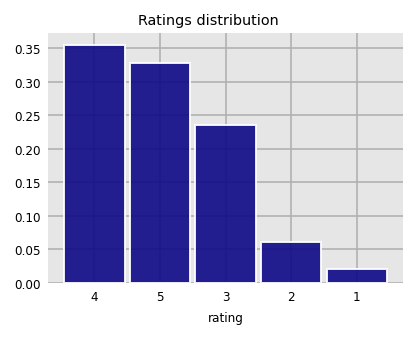

In [13]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

## Prediction models
In this section I will construct models and compare them:
1. Memory Based Collaborative Filtering - neighborhood algorithms :
   * User based
   * Item based
2. Matrix factorization
3. Random

Data preparation:

In [14]:
reader = Reader(rating_scale=(1, 5))
#Load ratings as dataset
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)

Divide data into train and test (20% of whole dataset) : 

In [15]:
train_size = int(0.8 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]
test_raw_ratings = raw_ratings[train_size:]
# data is now trainset
data.raw_ratings = train_raw_ratings

Let's create an empty list which will store the information about models.

In [16]:
models_info = []

### Memory Based Collaborative Filtering

I will use 4 different neighborhood algorithms defined in Surprise library : 
* <b>KNNBasic</b> 
* <b>KNNBaseline</b> 
* <b>KNNWithMean</b> 
* <b>KNNWithZScore</b> 

I will explore two different approaches : user-based and item-based. For each algorithm I will try to find hyperparameters which optimze two performance measures : <b>RMSE</b> (Root Mean Square Error) and <b>MAE</b> (Mean Absolute Error).

The parameters which will be optimized are:
* <b>k</b> - max number of neighbors to take into account for aggregation
* <b>min_k</b> - the minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings
* <b>sim_options name</b> - the name of the similarity to use

Parametr <b>user_based</b> defines if the similarity is user-based (user_based=True) or item_based (user_based=False).

For each approach dependence of RMSE and MAE scores on parameters will be visualized.

In [26]:
knn_model_dict = {'KNNBasic': KNNBasic,'KNNBaseline': KNNBaseline,
              'KNNWithZScore': KNNWithZScore, 'KNNWithMeans' :KNNWithMeans}
k_list = [5, 10]
min_k_list = [1, 2]
similarities_list = ['cosine', 'pearson']

<b>User-based</b>

 Best parameters for model KNNBasic are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}}
 Best parameters for model KNNBaseline are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': True}}}
 Best parameters for model KNNWithZScore are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': True}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': True}}}
 Best parameters for model KNNWithMeans are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': True}}}


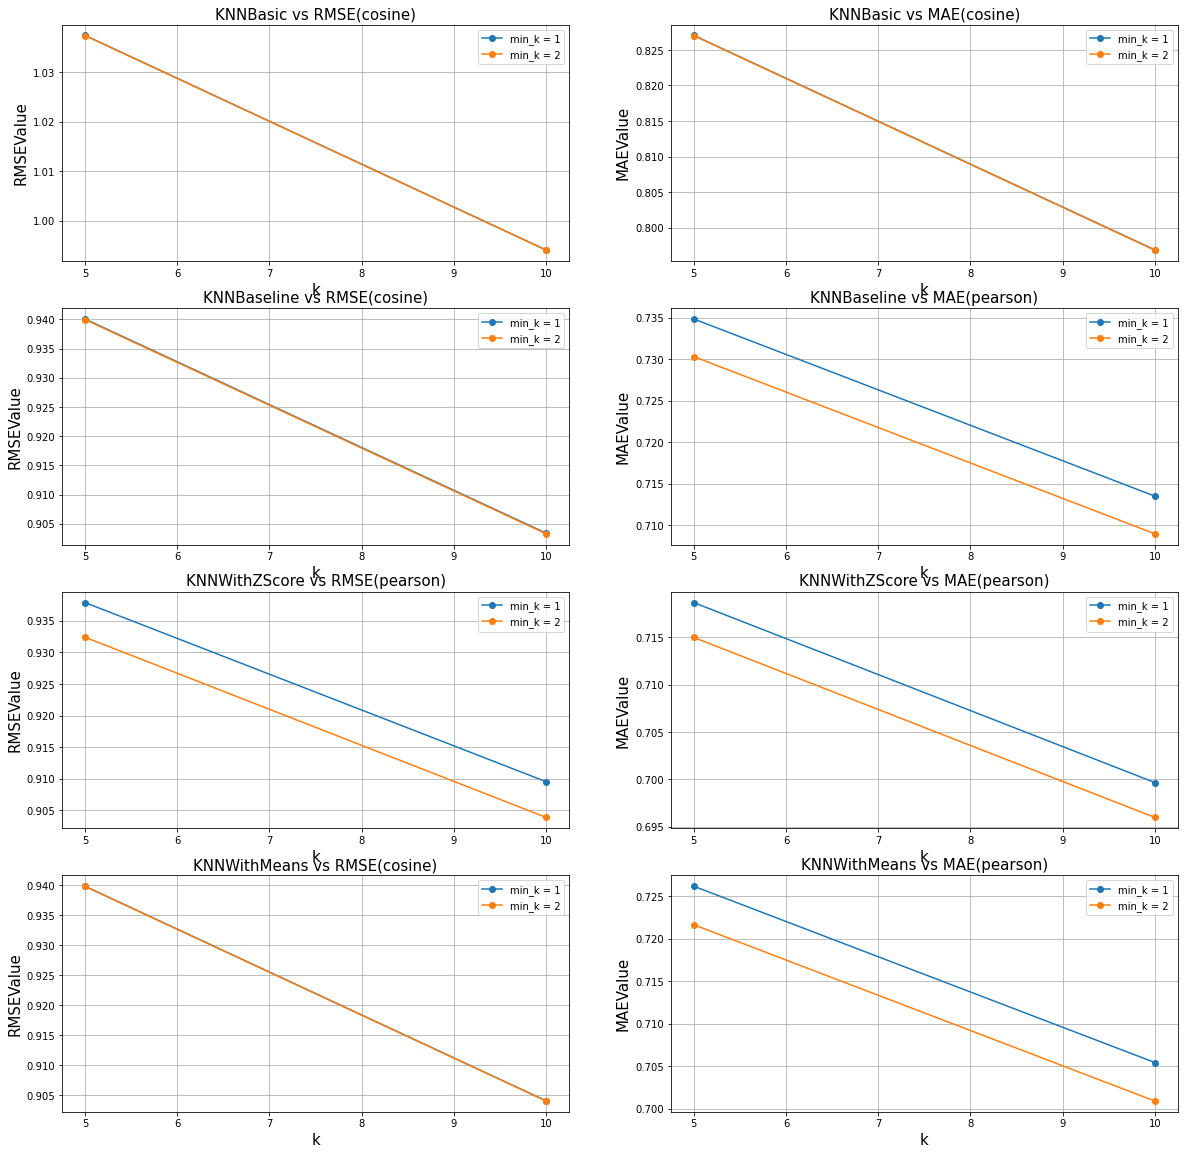

In [28]:
knn_result_user_based = grid_knn(data, knn_model_dict, k = k_list, min_k = min_k_list, similarities_list=similarities_list, user_based=[True])
hiper_visual(knn_result_user_based, min_k_list, k_list)

<b>Item-based</b>

 Best parameters for model KNNBasic are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}}
 Best parameters for model KNNBaseline are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}}
 Best parameters for model KNNWithZScore are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}}
 Best parameters for model KNNWithMeans are {'rmse': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 10, 'min_k': 2, 'sim_options': {'name': 'pearson', 'user_based': False}}}


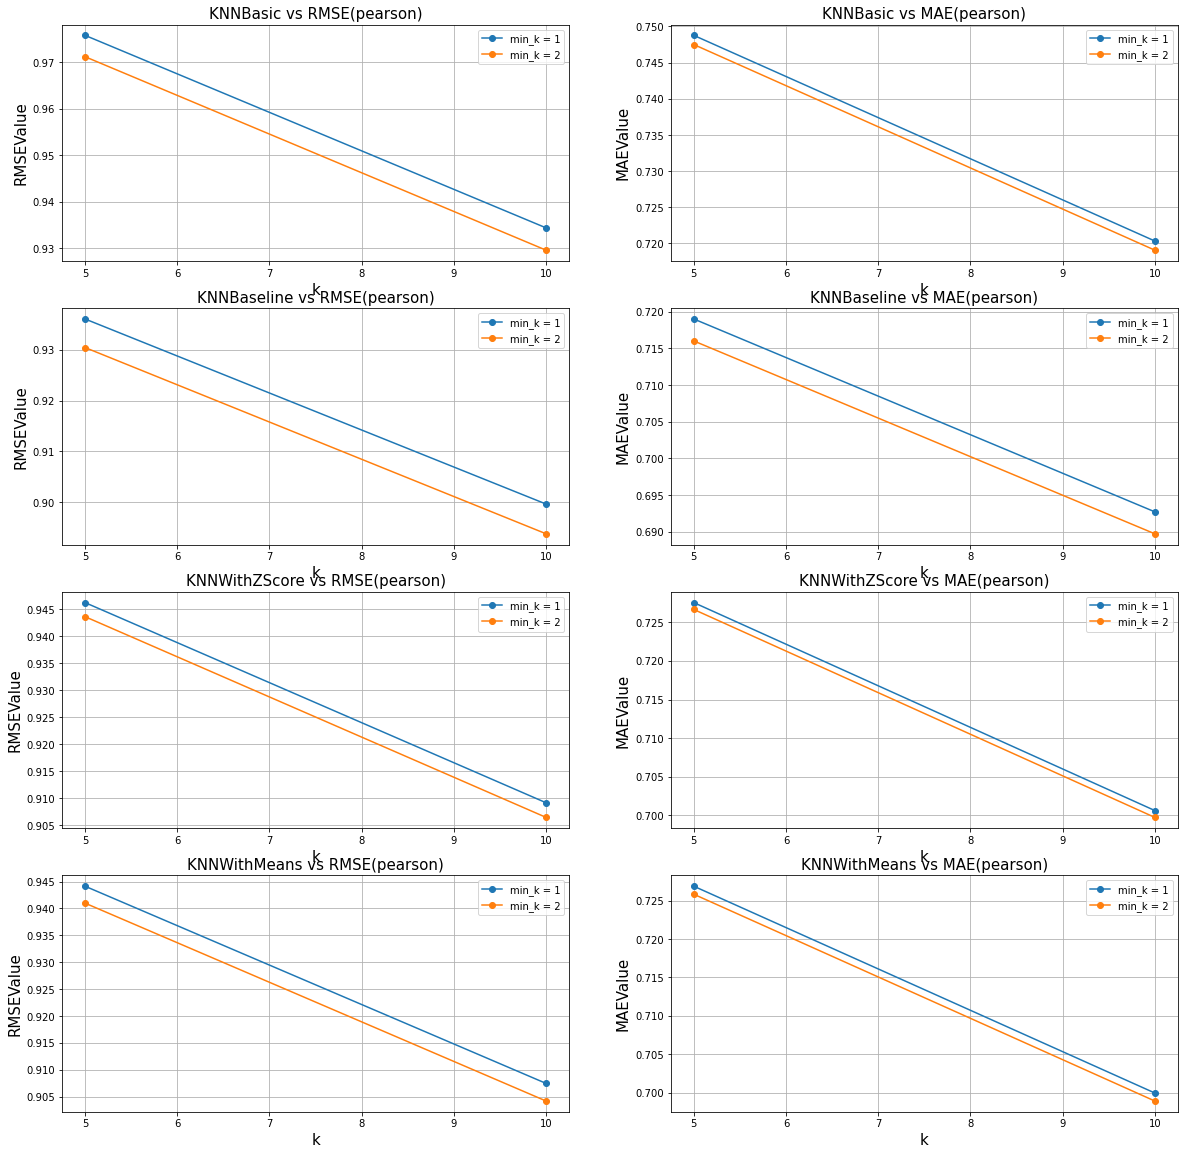

In [29]:
knn_result_item_based = grid_knn(data, knn_model_dict, k = k_list, min_k = min_k_list, similarities_list=similarities_list, user_based=[False])
hiper_visual(knn_result_item_based, min_k_list, k_list)

### Matrix Factorization

I will use two algorithms : SVD and SVD++.
See the Surprise documentation to read more about them: 
[documentation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).
The parameters which will be optimalyzed in gridsearch are:
* <b>n_epochs</b> - number of iteration of the SGD procedure
* <b>n_factors</b> - number of factors
* <b>lr_all</b> - learning rate for all parameters.
* <b>reg_all</b> - regularization term for all parameters

In [32]:
matrix_fact_dict = {'SVD' : SVD, 'SVD++' : SVDpp}

def grid_matrix_fact(model_dict, n_epochs=[10, 20, 30], lr_all=[0.01], cv=5):
    results_list = []
    #Define param grid
    param_grid = dict()
    param_grid['n_epochs'] = n_epochs
    param_grid['lr_all'] = lr_all
    for name, model in model_dict.items():
        grid = GridSearchCV(model,param_grid, cv=cv, n_jobs=-1)
        grid.fit(data)
        print(f' Best parameters for model {name} are {grid.best_params}')
        results_list.append((name, grid))
    return results_list

In [33]:
new_list = grid_matrix_fact(matrix_fact_dict)

 Best parameters for model SVD are {'rmse': {'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_epochs': 10, 'lr_all': 0.01}}
 Best parameters for model SVD++ are {'rmse': {'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_epochs': 10, 'lr_all': 0.01}}


### Random

This algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.
The predicted rating $r_{ui}$, for user u and book i, is generated from a normal distribution $\mathcal{N}(\hat{\mu},\hat{\sigma}^{2})$ where $\hat{\mu}$ and $\hat{\sigma}$ are estimated from the training set $R_{train}$ using Maximum Likelihood Estimation:[4]
$$
\hat{\mu} = \frac{1}{\lvert R_{train} \rvert} \sum\limits_{r_{ui}\in R_{train}} r_{ui}
$$

$$
\hat{\sigma} = \sqrt{ \sum\limits_{r_{ui}\in R_{train}} \frac{{(r_{ui} - \hat{\mu})}^{2}}{\lvert R_{train} \rvert}}
$$

In [38]:
model = NormalPredictor()
models_info.append(('Random', model))

In [40]:
models_info = models_info + knn_result_user_based + knn_result_item_based + new_list

In [41]:
models_info

[('Random',
  <surprise.prediction_algorithms.random_pred.NormalPredictor at 0x7ff0fb48fd60>),
 ('KNNBasic',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e1ce4be0>),
 ('KNNBaseline',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e2c632e0>),
 ('KNNWithZScore',
  <surprise.model_selection.search.GridSearchCV at 0x7ff15c7bd070>),
 ('KNNWithMeans',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0fb3fb580>),
 ('KNNBasic',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0de205be0>),
 ('KNNBaseline',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0de2050a0>),
 ('KNNWithZScore',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0fb378c70>),
 ('KNNWithMeans',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e1f453d0>),
 ('SVD', <surprise.model_selection.search.GridSearchCV at 0x7ff0fb385ee0>),
 ('SVD++', <surprise.model_selection.search.GridSearchCV at 0x7ff0fb385250>)]

<b>Comparison of all algorithms</b>

In [44]:
scorings = ['rmse', 'mae']

In [45]:
rmse = []
mae = []
for name, grid in models_info:
    print(name)                                                                                                                                
    # now test on the trainset                                                 
    trainset = data.build_full_trainset()
    testset = data.construct_testset(test_raw_ratings)
    for scoring_name in scorings:
        if name != 'Random':
            model = grid.best_estimator[scoring_name]
        else:
            model = grid
        model.fit(trainset)                                              
        predictions = model.test(testset)
        if scoring_name == 'rmse':
            rmse.append(accuracy.rmse(predictions))
        else:
            mae.append(accuracy.mae(predictions))

Random
RMSE: 1.3231
MAE:  1.0469
KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9869
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7886
KNNBaseline
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8923
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.6963
KNNWithZScore
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8891
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.6860
KNNWithMeans
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8944
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.6912
KNNBasic
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9201
Computing the pearson similarity matrix...

In [57]:
models_info

[('Random',
  <surprise.prediction_algorithms.random_pred.NormalPredictor at 0x7ff0fb48fd60>),
 ('KNNBasic',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e1ce4be0>),
 ('KNNBaseline',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e2c632e0>),
 ('KNNWithZScore',
  <surprise.model_selection.search.GridSearchCV at 0x7ff15c7bd070>),
 ('KNNWithMeans',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0fb3fb580>),
 ('KNNBasic',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0de205be0>),
 ('KNNBaseline',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0de2050a0>),
 ('KNNWithZScore',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0fb378c70>),
 ('KNNWithMeans',
  <surprise.model_selection.search.GridSearchCV at 0x7ff0e1f453d0>),
 ('SVD', <surprise.model_selection.search.GridSearchCV at 0x7ff0fb385ee0>),
 ('SVD++', <surprise.model_selection.search.GridSearchCV at 0x7ff0fb385250>)]

In [46]:
d = {'RMSE': rmse, 
     'MAE': mae
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[name for name, _ in models_info])
color = (df.RMSE == df.RMSE.min()).map({True: 'background-color: yellow', False: 'background_color: white'})
df.style.apply(lambda s: color)

,Method,RMSE,MAE
0,Random,1.323105,1.046949
1,KNNBasic,0.986929,0.788584
2,KNNBaseline,0.892302,0.696331
3,KNNWithZScore,0.889110,0.686044
4,KNNWithMeans,0.894426,0.691184
5,KNNBasic,0.920092,0.716606
6,KNNBaseline,0.885795,0.686697
7,KNNWithZScore,0.894471,0.693563
8,KNNWithMeans,0.893775,0.693712
9,SVD,0.864242,0.675666


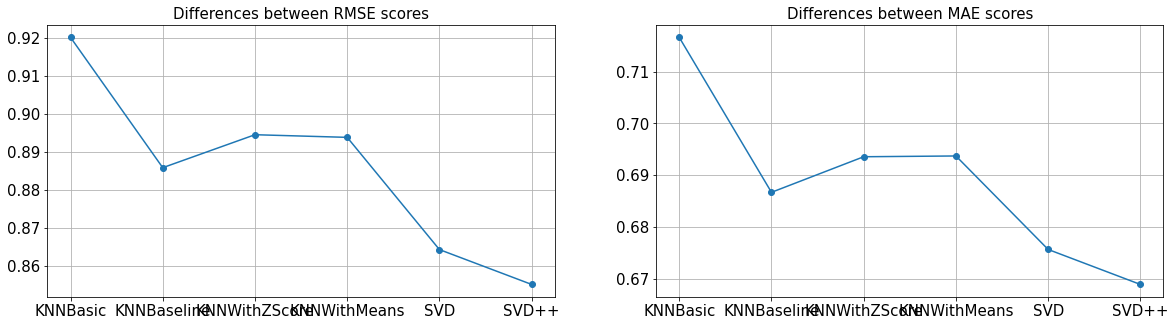

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_diff(df, 'Method', 'RMSE')
plt.subplot(1, 2, 2)
plot_diff(df, 'Method', 'MAE')
plt.show()

## Recommendations

Now we can finally recommend books for the users. 
Let's use the algorithm which has the lowest RMSE on test set.

In [64]:
model_idx = df['RMSE'].idxmin()
model = models_info[model_idx][1].best_estimator['rmse']
model

Let's recommend 10 books for user 51363.

In [74]:
top_n = get_top_n(51363, ratings, model,n=10)
get_names(top_n, books)

,book_id,prediction,pred_rating,authors,title
0,862,4.924830,5,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)"
1,780,4.796314,5,Bill Watterson,Calvin and Hobbes
2,135,4.778653,5,George R.R. Martin,"A Storm of Swords (A Song of Ice and Fire, #3)"
3,3628,4.762862,5,Bill Watterson,The Complete Calvin and Hobbes
4,1788,4.759262,5,Bill Watterson,The Calvin and Hobbes Tenth Anniversary Book
5,1496,4.745549,5,George R.R. Martin,A Storm of Swords: Blood and Gold (A Song of I...
6,1308,4.708919,5,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...
7,2852,4.702361,5,Koushun Takami,Battle Royale
8,769,4.682903,5,Arthur Conan Doyle,The Complete Sherlock Holmes
9,562,4.679416,5,Brandon Sanderson,"The Way of Kings (The Stormlight Archive, #1)"


Let's look at the list of books which user 51363 gave rate 5 and compare it to recommendation list

In [75]:
get_names(ratings[(ratings.rating == 5) & (ratings.user_id == 51363)], books)

,user_id,book_id,rating,authors,title
0,51363,1269,5,Richard Preston,The Hot Zone: The Terrifying True Story of the...
1,51363,358,5,Dr. Seuss,"Oh, The Places You'll Go!"
2,51363,626,5,Chris Van Allsburg,The Polar Express
3,51363,50,5,Shel Silverstein,Where the Sidewalk Ends
4,51363,278,5,Shel Silverstein,A Light in the Attic
5,51363,7,5,J.R.R. Tolkien,The Hobbit
6,51363,2,5,J.K. Rowling,Harry Potter and the Sorcerer's Stone (Harry P...
7,51363,21,5,J.K. Rowling,Harry Potter and the Order of the Phoenix (Har...
8,51363,18,5,J.K. Rowling,Harry Potter and the Prisoner of Azkaban (Harr...
9,51363,3158,5,Tess Gerritsen,"The Apprentice (Rizzoli & Isles, #2)"


#  References
1. https://medium.com/recommendation-systems/user-based-vs-item-based-collaborative-filtering-d40bb49c7060
2. http://surprise.readthedocs.io/en/stable/getting_started.html
3. https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1
4. https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor